# Advanced Lane Detection

Thanks for Udacity chaps for bringing up Self-Driving Car Nano Degree. This article gives short summary about the project.

## Introduction

Goal of the project is to detect lane lines from given videos and annotate lane lines on video stream and measure lane line curvature and car's offset from the lane center.


Project can be divided into following steps
* Analyse given videos and come up with the plan to create lane line detection algorithm
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


[//]: # (Image References)
[image1]: ./illustrations/project_video.mp4_straight_lane.jpg "project_video.mp4: straight lane portion"
[image2]: ./illustrations/project_video.mp4_border_of_dark_and_bright_road.jpg "project_video.mp4: Change from dark road to bright road."
[image3]: ./illustrations/project_video.mp4_curve.jpg "project_video.mp3: Curve:



[//]: # (Video References)
[video1]: ./video.mp4 "Final result: Car driving autonomously"

[//]: # (Article References)
[1]: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9



## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

### Writeup / README

#### 1. Provide a Writeup 
This report is a writeup


[//]: # (Image References)
[image1]: ./illustrations/project_video.mp4_straight_lane.jpg "project_video.mp4: straight lane portion"
[image2]: ./illustrations/project_video.mp4_border_of_dark_and_bright_road.jpg "project_video.mp4: Change from dark road to bright road."
[image3]: ./illustrations/project_video.mp4_curve.jpg "project_video.mp3: Curve"



## Video Analysis

In this section i give brief summary and analysis of three given videos.

### 1. 'project_video.mp4'

This video is mandatory to meet project specification.

Video consist of seemingly quite high contrast lane lines. 
![straight lane portion][image1]
![curve][image3]

There is one place where road contrast changes significantly.

![Change from dark road to bright road.][image2]


### 2. 'challenge_video.mp4'

This video is optional challenge.

### 3. 'harder_challenge_video.mp4'

This video is optional challenge.



In [2]:
# In this code cell i show basic statistics of video and video will be played
%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip1 = VideoFileClip("project_video.mp4")
print("Duration of clip: ", clip1.duration)
print("FPS of clip:, ", clip1.fps)
i_frame_ms = 1 / clip1.fps * 1000  # Interval between frames in milliseconds
print("Interval between frames {}ms".format(i_frame_ms))
frame_iter = clip1.iter_frames()
 
for frame in frame_iter:
    #frame = clip1.get_frame(i)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('image', frame)
    if cv2.waitKey(int(i_frame_ms)) & 0xFF == ord('q'):
        break
cv2.waitKey(5000)
cv2.destroyAllWindows()

Duration of clip:  50.4
FPS of clip:,  25.0
Interval between frames 40.0ms


In [1]:
# In this code cell i'll take snapshot of video to show features of video.

%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_file = "project_video.mp4"
clip1 = VideoFileClip(video_file)
save_path = "./illustrations/"
capture_location = ((15., "_straight_lane"), (21.,"_border_of_dark_and_bright_road"), (27., "_curve"))
for loc, name in capture_location:
    frame = clip1.get_frame(loc)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path+video_file+name+".jpg", frame)

In [2]:
# In this code cell i'll take snapshot of video to show features of video.

%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_file = "challenge_video.mp4"
clip1 = VideoFileClip(video_file)
save_path = "./illustrations/"
capture_location = ((1., "_tarmac_edge_separates"), (4.,"_shadow"), (14., "_tarmac_edge_joins"))
for loc, name in capture_location:
    frame = clip1.get_frame(loc)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path+video_file+name+".jpg", frame)

In [3]:
# In this code cell i'll take snapshot of harder challenge video to show features of video.

%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_file = "harder_challenge_video.mp4"
clip1 = VideoFileClip(video_file)
save_path = "./illustrations/"
capture_location = ((3.5, "_yellow_line_occlusion"), (10, "_white_line_occlusion"), (34.,"_over_exposed"), (41., "_right_line_not_in_view"))
for loc, name in capture_location:
    frame = clip1.get_frame(loc)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path+video_file+name+".jpg", frame)

## Camera calibration

In [9]:
# Find corners

%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tqdm

# define criteria to stop corner subpixel search
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Number of inside corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

img = cv2.imread("./camera_cal/calibration2.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
if ret:
    cv2.cornerSubPix(gray,corners,(11,11),(-1,-1), criteria)
    imgpoints.append(corners)

    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners,ret)
    plt.figure(figsize=(10,10))
    
    plt.title("Corners Found!")
    plt.axis('off')
    plt.imsave("./illustrations/calib_corners_found.jpg", img)
    plt.imshow(img)
    
else:
    print("No corners found.")

Finding corners:   0%|          | 0/20 [00:00<?, ?it/s]

Finding corners:   5%|▌         | 1/20 [00:01<00:21,  1.15s/it]

Finding corners:  10%|█         | 2/20 [00:01<00:16,  1.06it/s]

Finding corners:  15%|█▌        | 3/20 [00:02<00:14,  1.15it/s]

Finding corners:  20%|██        | 4/20 [00:02<00:10,  1.55it/s]

Finding corners:  25%|██▌       | 5/20 [00:02<00:08,  1.71it/s]

Finding corners:  30%|███       | 6/20 [00:03<00:08,  1.73it/s]

Finding corners:  35%|███▌      | 7/20 [00:03<00:07,  1.77it/s]

Finding corners:  40%|████      | 8/20 [00:04<00:06,  1.83it/s]

Finding corners:  45%|████▌     | 9/20 [00:04<00:05,  2.08it/s]

Finding corners:  50%|█████     | 10/20 [00:05<00:04,  2.02it/s]

Finding corners:  55%|█████▌    | 11/20 [00:06<00:05,  1.60it/s]

Finding corners:  60%|██████    | 12/20 [00:06<00:04,  1.68it/s]

Finding corners:  65%|██████▌   | 13/20 [00:07<00:04,  1.57it/s]

Finding corners:  70%|███████   | 14/20 [00:07<00:03,  1.71it/s]

Finding corners:  75%|███████▌  | 15/20 [00:08<00:02,  1.95it/s]

Finding corners:  80%|████████  | 16/20 [00:08<00:02,  1.87it/s]

Finding corners:  85%|████████▌ | 17/20 [00:09<00:01,  2.47it/s]

Finding corners:  90%|█████████ | 18/20 [00:09<00:00,  2.06it/s]

Finding corners:  95%|█████████▌| 19/20 [00:10<00:00,  2.05it/s]

Finding corners: 100%|██████████| 20/20 [00:10<00:00,  2.04it/s]

Successfully read corners of 17/20 images.


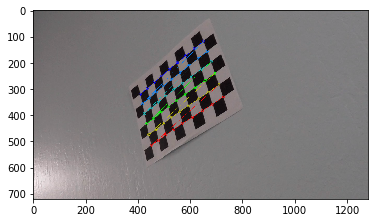

In [4]:
# Camera calibration
# http://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/bf149677-e05e-4813-a6ea-5fe76021516a
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a30f45cb-c1c0-482c-8e78-a26604841ec0

%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tqdm

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Number of inside corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('./camera_cal/*.jpg')
counter = 0
for fname in tqdm.tqdm(images, desc="Finding corners"):
    #print("reading: ", fname, end='')
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    # If found, add object points, image points (after refining them)
    if ret:
        counter += 1
        objpoints.append(objp)

        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners,ret)
        #cv2.imshow('img',img)
        plt.imshow(img)
        #cv2.waitKey(500)

print("Successfully read corners of {}/{} images.".format(counter, len(images)))
#cv2.destroyAllWindows()

In [5]:
# Calculate calibration coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [10]:
# Undistort
# http://docs.opencv.org/trunk/dc/dbb/tutorial_py_calibration.html
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

img = cv2.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, None)

img2 = cv2.imread('./test_images/straight_lines2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
dst2 = cv2.undistort(img2, mtx, dist, None, None)

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Original and Undistorted Images", fontsize=20)

a = fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(img)
a = fig.add_subplot(2, 2, 2)
plt.title("Undistorted")
plt.axis('off')
plt.imshow(dst)

a = fig.add_subplot(2, 2, 3)
plt.axis('off')
plt.title("Original")
plt.imshow(img2)
a = fig.add_subplot(2, 2, 4)
plt.title("Undistorted")
plt.axis('off')
plt.imshow(dst2)

plt.savefig("./illustrations/calib_original_and_undistorted.jpg")
plt.savefig("./output_images/tmp.jpg")

In [6]:
# Crop Image
%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from Camera import VideoClipMPY as Cam

#video_file = "project_video.mp4"
#video_file = "challenge_video.mp4"
video_file = "harder_challenge_video.mp4"


cam = Cam(video_file)
i_frame_ms = 1 / cam.clip.fps * 1000
for frame in cam:
    # NOTE: its img[y: y + h, x: x + w]
    frame = frame[400:720, 0:1280]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('video', frame)
    if cv2.waitKey(int(i_frame_ms)) & 0xFF == ord('q'):
        break
        
cv2.waitKey(1000)
cv2.destroyWindow('video')

## Warp images

In [11]:
from Camera.UdacityAdvLane import UdacityAdvLane as Ucam 
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

filename = 'project_video.mp4'
udacam = Ucam(filename)

image = cv2.imread("./test_images/straight_lines2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = udacam.undistort(image)
plt.imsave("./illustrations/cam_undistorted.jpg", undistorted)
cropped = udacam.crop(undistorted)
plt.imsave("./illustrations/cam_undistorted_cropped.jpg", cropped)
warped = udacam.warp(cropped)
plt.imsave("./illustrations/cam_undistorted_cropped_warped.jpg", warped)

# Draw warp points to cropped image
src = udacam.transformation.src_points
vertices_src = src.reshape((-1,1,2)).astype(dtype=np.int32)
cv2.polylines(cropped, [vertices_src], True, [0,255,0], 3)

# Draw warp points to warped image
dst = udacam.transformation.dst_points
vertices_dst = dst.reshape((-1,1,2)).astype(dtype=np.int32)
cv2.polylines(warped, [vertices_dst], True, [255,0,0], 2)


fig = plt.figure(figsize=(15, 10))
fig.suptitle("Warped Image", fontsize=20)

#Show original image
a = fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title("Cropped")
plt.imshow(cropped)
# Show warped image
a = fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title("Warped")
plt.imshow(warped)
#plt.show()
plt.savefig("./illustrations/cam_undistorted_cropped_warped_points.jpg")

# Exploring Color Channels

In [19]:
# Load test image for exploring color channels
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Camera.UdacityAdvLane import UdacityAdvLane as Ucam 
%matplotlib inline

filename = 'project_video.mp4'
udacam = Ucam(filename)

original = cv2.imread("./test_images/test4.jpg")
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
image = udacam.apply_pipeline(rgb)


def show_orig_and_channels(title, images, descriptions):
    """Creates a plot from 4 images with title and descriptions"""
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle(title, fontsize=20) # If problems with title location, try y-parameter "y=1.02"
    for i, x in enumerate(zip(images, descriptions)):
        im, title = x
        a = fig.add_subplot(1, 4, i+1)
        plt.axis('off')
        plt.title(title)
        plt.imshow(im, cmap='gray')
    #plt.show()

## RGB ( Red, Green and Blue )

In [20]:
# Split RGB
R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]

show_orig_and_channels("RGB color channels splitter.",
                       [image, R, G, B],
                       ["Original","Red", "Green", "Blue"])

plt.savefig("./illustrations/color_channels_rgb.jpg")

In RGB color space we could possibly use channels following way
- Red --> yellow & white
- Green --> white
- Blu --> white

## HLS ( Hue, Lightness, Saturation )

In [21]:
# Split HLS
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

H, L, S = hls[:,:,0], hls[:,:,1], hls[:,:,2]

show_orig_and_channels("HLS color channels splitter.",
                       [image, H, L, S],
                       ["Original","Hue", "Lightness", "Saturation"])

plt.savefig("./illustrations/color_channels_hls.jpg")

In HLS color space we could do following
- Use HUE to detect yellow, pixel values around 40 in float32 images, uint8 around 20
  * Center around 0
  * Cut everything away within +-20 margin
  * Normalize
  * Construct function which transfers 0 --> 1 and values 
- Saturation for white and yellow lines
- Lightness for white lines, there should be some sort of normalization i guess


## Lab ( Lightness, a (green–red) and b (blue–yellow) )

In [22]:
# Split Lab
Lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

L, a, b = Lab[:,:,0], Lab[:,:,1], Lab[:,:,2]

show_orig_and_channels("Lab Color Channels.",
                       [image, L, a, b],
                       ["Original","Lightness", "a (green–red)", "b (blue–yellow)"])

plt.savefig("./illustrations/color_channels_Lab.jpg")

In Lab color space we could utilize
- b-channel for yellow
- Lightness for white

## YUV

In [23]:
# Split YUV
YUV = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

Y, U, V = YUV[:,:,0], YUV[:,:,1], YUV[:,:,2]

show_orig_and_channels("YUV Color Channels.",
                       [image, Y, U, V],
                       ["Original","Y", "U", "V"])

plt.savefig("./illustrations/color_channels_YUV.jpg")

in YUV color space we could utilize following show_orig_and_channels
- Y for white
- U for yellow

## LUV

In [24]:
# Split LUV
LUV = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

L, U, V = LUV[:,:,0], LUV[:,:,1], LUV[:,:,2]

show_orig_and_channels("LUV color channels splitter.",
                       [image, L, U, V],
                       ["Original","L", "U", "V"])

plt.savefig("./illustrations/color_channels_LUV.jpg")

LUV color channels could be utilized in this way
- L -detect white
- U&V Detect yellow

## YCrCb

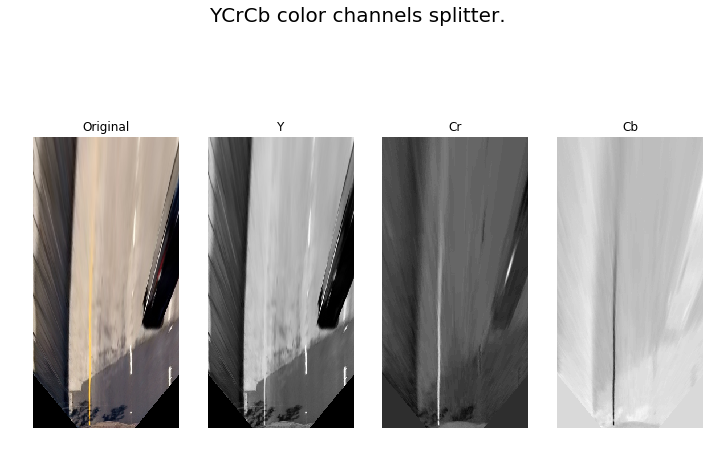

In [25]:
# Split YCR_CB
YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)

Y, Cr, Cb = YCrCb[:,:,0], YCrCb[:,:,1], YCrCb[:,:,2]

show_orig_and_channels("YCrCb color channels splitter.",
                       [image, Y, Cr, Cb],
                       ["Original","Y", "Cr", "Cb"])

plt.savefig("./illustrations/color_channels_YCrCb.jpg")

YCRCb color channels could be utilized in following way.
- Y to detect white
- Cr to detect yellow
- Cb to to detect yellow as inverse image

# Combine color spaces

In this section i will study how to combine color spaces to produce meaning ful predictions of lane pixels


In [26]:
# Load test image for exploring color channels combinations
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Camera.UdacityAdvLane import UdacityAdvLane as Ucam 
%matplotlib inline

filename = 'project_video.mp4'
udacam = Ucam(filename)

original = cv2.imread("./test_images/test4.jpg")
pipelined = udacam.apply_pipeline(original)

# First convert to float for more accurate color space conversions and for easier math
float_img = pipelined.copy().astype('float32')
print("Float image min = {} and max = {} before normalization".format(float_img.min(), float_img.max()))
float_img /= 255
print("Float image min = {} and max = {} after normalization".format(float_img.min(), float_img.max()))

# Use float_img in further down to do color space conversions and math

Float image min = 0.0 and max = 255.0 before normalization
Float image min = 0.0 and max = 1.0 after normalization


In [27]:
# Split into different color spaces
# print little bit statistics
print("Shape of image:    ", float_img.shape)
print("Datatype of image: ", float_img.dtype)

# 1. BGR split
image = float_img
RGB_B, RGB_G, RGB_R = image[:,:,0], image[:,:,1], image[:,:,2]

# 2. HLS split
colorspace = cv2.COLOR_BGR2HLS
image_hls = cv2.cvtColor(image, colorspace)
HLS_H, HLS_L, HLS_S = image_hls[:,:,0], image_hls[:,:,1], image_hls[:,:,2]

# 3. Lab split
colorspace = cv2.COLOR_BGR2Lab
image_lab = cv2.cvtColor(image, colorspace)
Lab_l, Lab_a, Lab_b = image_lab[:,:,0], image_lab[:,:,1], image_lab[:,:,2]

# 4. LUV split
colorspace = cv2.COLOR_BGR2Luv
image_luv = cv2.cvtColor(image, colorspace)
LUV_L, LUV_U, LUV_V = image_luv[:,:,0], image_luv[:,:,1], image_luv[:,:,2]

Shape of image:     (512, 256, 3)
Datatype of image:  float32


In [28]:
# Let's first try to get more certain about yellow channel.
# by using channels hls_s, lab_b, luv_v

from LaneFinder.colors import normalize_plane 

# First we need to check data range of these channels. 
# We want those to be within range 0...1
print("HLS_S min = {}, max = {}".format(HLS_S.min(), HLS_S.max()))
print("Lab_b min = {}, max = {}".format(Lab_b.min(), Lab_b.max()))
print("LUV_V min = {}, max = {}".format(LUV_V.min(), LUV_V.max()))

# HLS_S fulls our requirementes
# Lab_b and LUV_V need to be normalized
Lab_b_norm = normalize_plane(Lab_b)
LUV_V_norm = normalize_plane(LUV_V)

# After normalization
print("Lab_b min = {}, max = {}".format(Lab_b_norm.min(), Lab_b_norm.max()))
print("LUV_V min = {}, max = {}".format(LUV_V_norm.min(), LUV_V_norm.max()))


show_orig_and_channels("Normalized color planes for yellow detection",
                       [float_img, HLS_S, Lab_b_norm, LUV_V_norm],
                       ["Original","HLS_S", "Lab_b", "LUV_V"])

HLS_S min = 0.0, max = 1.0
Lab_b min = -17.75931739807129, max = 76.01251983642578
LUV_V min = -19.0383358001709, max = 83.47802734375
Lab_b min = 0.0, max = 1.0
LUV_V min = 0.0, max = 1.0


### Find yellow color

color plane shape:  (512, 256)


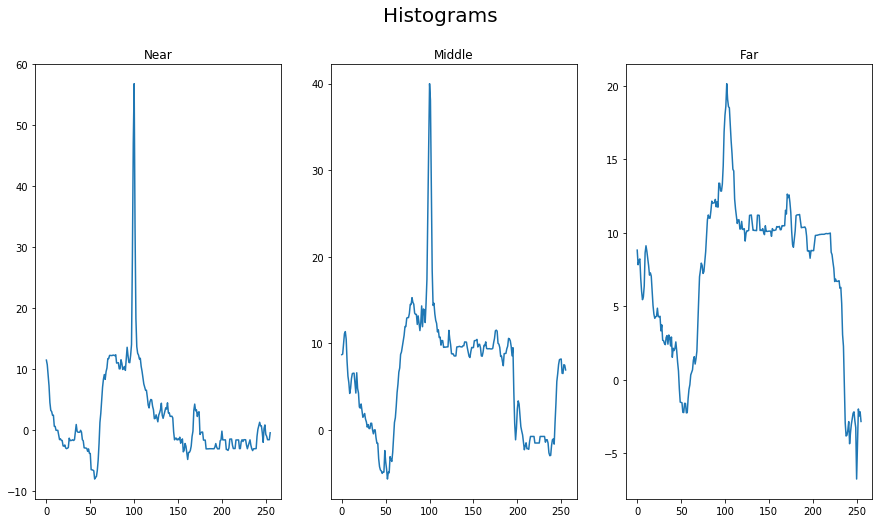

In [29]:
row_near = 400
row_middle = 280
row_far = 150
cplane = Lab_b
print("color plane shape: ", cplane.shape)
histogram_near = cplane[row_near]
histogram_middle = cplane[row_middle]
histogram_far = cplane[row_far]


fig = plt.figure(figsize=(15, 8))
fig.suptitle("Histograms", fontsize=20)

#Show histogram near
a = fig.add_subplot(1, 3, 1)
plt.title("Near")
plt.plot(histogram_near)

# Show histogram middle
a = fig.add_subplot(1, 3, 2)
plt.title("Middle")
plt.plot(histogram_middle)

# Show histogram far
a = fig.add_subplot(1, 3, 3)
plt.title("Far")
plt.plot(histogram_far)

plt.show()

shape of cplanes:  (512, 256, 12)
color plane shape:  (512, 256)


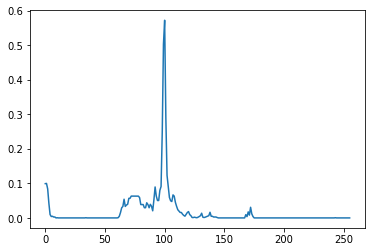

In [30]:
# Run Through functions which reveals yellow colors
from scipy.special import expit # expit is  a sigmoid function
from LaneFinder import colors


row = row_near

cplanes = colors.bgr2cpaces(image)
print("shape of cplanes: ", cplanes.shape)
yellow = colors.yellow_color_plane(cplanes)
#yellow = cv2.GaussianBlur(yellow, ksize=(3,3), sigmaX=0)
print("color plane shape: ", yellow.shape)
#histogram = cplane[row]
histogram = yellow[row]
#histogram = np.sum(cplane[row:, :], axis=0)


plt.plot(histogram)
#plt.imshow(yellow, cmap='gray')

### Find White

Below is explanation how to find white by using Lab-L color plane

color plane shape:  (512, 256)


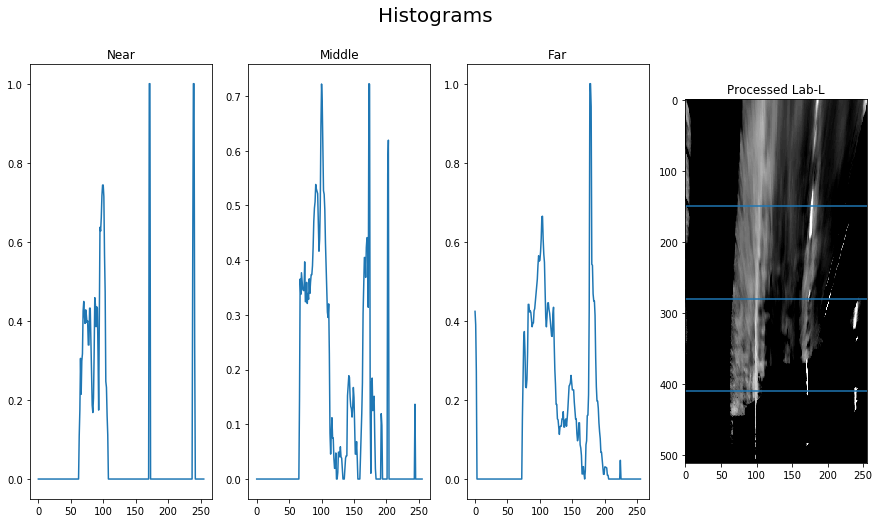

In [33]:
%matplotlib inline
row_near = 410
row_middle = 280
row_far = 150
cplane = colors.normalize_plane( np.clip(Lab_l, 70, 90))
#print("color plane shape: ", cplane.shape)
histogram_near = cplane[row_near]
histogram_middle = cplane[row_middle]
histogram_far = cplane[row_far]


fig = plt.figure(figsize=(15, 8))
fig.suptitle("Histograms", fontsize=20)

#Show histogram near
a = fig.add_subplot(1, 4, 1)
plt.title("Near")
plt.plot(histogram_near)

# Show histogram middle
a = fig.add_subplot(1, 4, 2)
plt.title("Middle")
plt.plot(histogram_middle)

# Show histogram far
a = fig.add_subplot(1, 4, 3)
plt.title("Far")
plt.plot(histogram_far)

# Show picture
a = fig.add_subplot(1, 4, 4)
plt.title("Processed Lab-L")
plt.axhline(row_near)
plt.axhline(row_middle)
plt.axhline(row_far)
plt.imshow(cplane, cmap='gray')


#plt.show()
plt.savefig("./illustrations/color_white_from_lab_l.jpg")

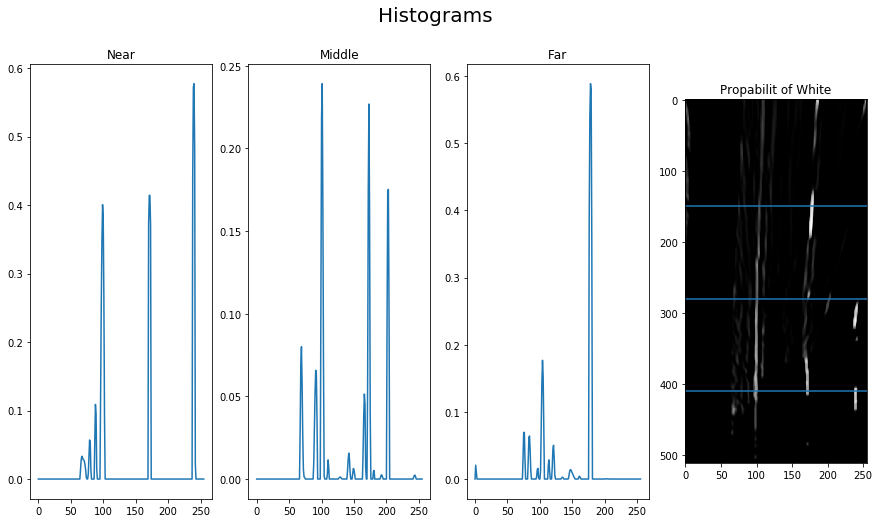

In [39]:
## Propability of white
%matplotlib inline
from LaneFinder.finder import find_white_lane_pixel_props
from LaneFinder.colors import bgr_uint8_2_cpaces_float32
row_near = 410
row_middle = 280
row_far = 150

#colorspace = cv2.COLOR_BGR2HLS
#image_hls = cv2.cvtColor(image, colorspace)
cplanes = bgr_uint8_2_cpaces_float32(pipelined)
cplane = find_white_lane_pixel_props(cplanes)
#print("color plane shape: ", cplane.shape)
histogram_near = cplane[row_near]
histogram_middle = cplane[row_middle]
histogram_far = cplane[row_far]


fig = plt.figure(figsize=(15, 8))
fig.suptitle("Histograms", fontsize=20)

#Show histogram near
a = fig.add_subplot(1, 4, 1)
plt.title("Near")
plt.plot(histogram_near)

# Show histogram middle
a = fig.add_subplot(1, 4, 2)
plt.title("Middle")
plt.plot(histogram_middle)

# Show histogram far
a = fig.add_subplot(1, 4, 3)
plt.title("Far")
plt.plot(histogram_far)

# Show picture
a = fig.add_subplot(1, 4, 4)
plt.title("Propabilit of White")
plt.axhline(row_near)
plt.axhline(row_middle)
plt.axhline(row_far)
plt.imshow(cplane, cmap='gray')


#plt.show()
#plt.savefig("./illustrations/color_white_propability.jpg")

shape of cplanes:  (512, 256, 12)


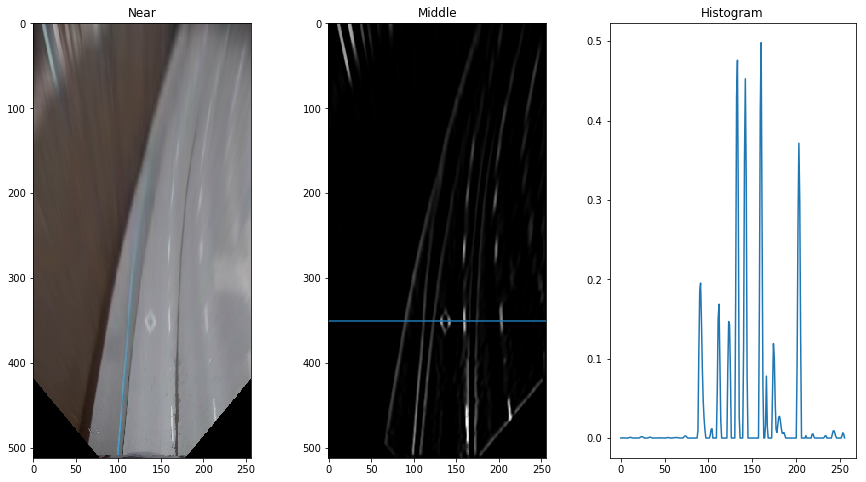

In [61]:
# Run Through functions which reveals 'white' color

from LaneFinder import colors
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Camera.UdacityAdvLane import UdacityAdvLane as Ucam 
%matplotlib inline

# Rows for test4.jpg
row_near = 445
row_middle = 280
row_far = 150



filename = 'project_video.mp4'
udacam = Ucam(filename)

#original = cv2.imread("./test_images/test4.jpg")
original = cv2.imread("./illustrations/challenge_video.mp4_tarmac_edge_separates.jpg")
pipelined = udacam.apply_pipeline(original)

# Convert to float image
float_img = pipelined.copy().astype('float32') / 255

print("shape of cplanes: ", cplanes.shape)

gamma = 1
cplanes = colors.bgr2cpaces(float_img)
#white = find_white_lane_lines(cplanes)
white_hls_l = cplanes[:, :, 4]
rgb_r = colors.normalize_plane( cplanes[:, :, 0] )

##
## BUILD A PIPELINE
white = white_hls_l * rgb_r
white = cv2.GaussianBlur(white, ksize=(5,5), sigmaX=3, sigmaY=3)
sobel = cv2.Sobel(white, cv2.CV_32F, 1, 0, ksize=3)
kernel9 = np.array([[0, 0, 3, 0, 0, 0, -3,  0,  0],
                    [0, 5, 5, 0, 0, 0, -5, -5,  0],
                    [0, 5, 5, 0, 0, 0, -5, -5, 0],
                    [0, 5, 5, 0, 0, 0, -5, -5, 0],
                    [0, 5, 5, 0, 0, 0, -5, -5, 0],
                    [0, 5, 5, 0, 0, 0, -5, -5, 0],
                    [0, 5, 5, 0, 0, 0, -5, -5, 0],
                    [0, 5, 5, 0, 0, 0, -5, -5,  0],
                    [0, 0, 3, 0, 0, 0, -3,  0,  0]], dtype=np.float32) / 25

kernel7 = np.array([[0, 2, 1, 0, -1, -2, 0],
                    [1, 3, 2, 0, -2, -3, -1],
                    [2, 3, 2, 0, -2, -3, -2],
                    [2, 3, 2, 0, -2, -3, -2],
                    [2, 3, 2, 0, -2, -3, -2],
                    [1, 3, 2, 0, -2, -3, -1],
                    [0, 2, 1, 0, -1, -1, 0]], dtype=np.float32) / 25

kernel5 = np.array([[2, 3, 1, -3, -2],
                   [2, 3, 1, -3, -2],
                   [2, 3, 1, -3, -2],
                   [2, 3, 1, -3, -2],
                   [2, 3, 1, -3, -2]], dtype=np.float32) / 25
filter = cv2.filter2D(sobel,-1, kernel7)
white_hls_l = cv2.GaussianBlur(white_hls_l, ksize=(5,5), sigmaX=3, sigmaY=3)
filter = np.clip(filter, 0, 1) * white_hls_l * rgb_r

# Define historgram row
row = 350  # Set row
histogram = filter[row]

fig = plt.figure(figsize=(15, 8))
#plt.imshow(white, cmap='gray')
#plt.imsave("white_lane.jpg", white*255, cmap='gray')

#Show warped
a = fig.add_subplot(1, 3, 1)
plt.title("Near")
plt.imshow(pipelined)

# Show warped white
a = fig.add_subplot(1, 3, 2)
plt.title("Middle")
plt.axhline(row)
plt.imshow(filter, cmap='gray')

# Show histogram
a = fig.add_subplot(1, 3, 3)
plt.title("Histogram")
plt.plot(histogram)

plt.show()

In [43]:
def weighted_snr(array):
    avg = np.average(histogram)
    max = np.max(histogram)
    snr = max / avg
    return snr * max
#print("weighted snr on histogram: ", weighted_snr(histogram))
#for x in histogram[150:180]:
    #print ("{:.1f}".format(x))

0.0
0.0
0.0
0.0
0.0
0.1
0.2
0.2
0.1
0.0
-0.0
-0.1
-0.2
-0.2
-0.2
-0.1
-0.2
-0.2
-0.2
-0.1
-0.0
0.1
0.1
0.2
0.1
0.1
0.0
0.0
0.0
0.0


## Test yellow and white color planes

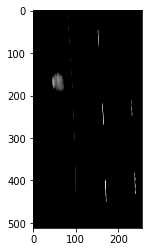

In [8]:
# Load test image for exploring color channels
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Camera.UdacityAdvLane import UdacityAdvLane as Ucam
from LaneFinder import finder
from LaneFinder import colors

%matplotlib inline

filename = 'project_video.mp4'
#filename = 'challenge_video.mp4'
#filename = 'harder_challenge_video.mp4'
udacam = Ucam(filename)
pfilter = finder.load_propability_filter()


for frame in udacam:
    # Convert from RGB to BGR
    bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # Convert to float image
    float_im = bgr.copy().astype('float32') / 255
    blurred = cv2.GaussianBlur(float_im, ksize=(9,9), sigmaX=1, sigmaY=9)
    cplanes = colors.bgr2cpaces(blurred)
    #lanes, py, pw = finder.find_lane_pixels(cplanes, pfilter, gamma_y=0.3, gamma_w=0.3)
    #lanes = finder.find_white_lane_pixel_props(cplanes)
    lanes = colors.white_centric_lab_l(cplanes[:, :, 6])
    
    plt.imshow(lanes, cmap='gray')
    plt.show()
    
    lanes3x = np.dstack((lanes, lanes, lanes))
    result = np.hstack((float_im, lanes3x))
    cv2.imshow('result', result)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    break
cv2.waitKey(1000)
cv2.destroyAllWindows()

## Test Thresholds

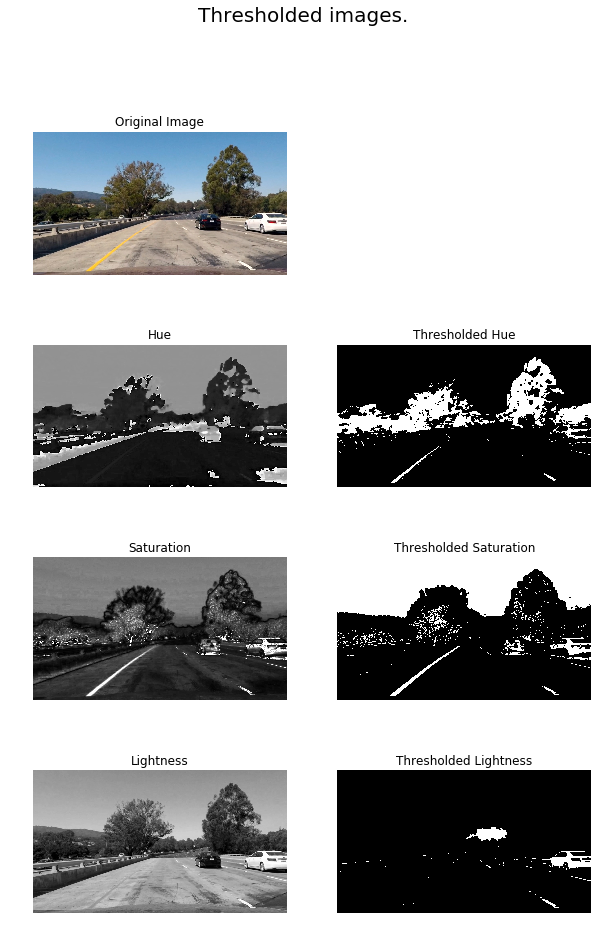

In [4]:
# Test out HSL thresholding
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = cv2.imread('./test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, None)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

# Detect and threshold yellow line on Hue-Channel
thresh = (20, 70)
gray = H
binary_yh = np.zeros_like(gray)
binary_yh[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Detect and threshold yellow and white line on Saturation-Channel
thresh = (110, 255)
gray = S
binary_yws = np.zeros_like(gray)
binary_yws[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Detect and threshold white line on Lightness-Channel
thresh = (200, 255)
gray = L
binary_wl = np.zeros_like(gray)
binary_wl[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Image, Name, cmap
images = [#[rgb,        "Original",               None],
          [H,          "Hue",                    "gray"],
          [binary_yh,  "Thresholded Hue",        "gray"],
          [S,          "Saturation",             "gray"],
          [binary_yws, "Thresholded Saturation", "gray"],
          [L,          "Lightness",              "gray"],
          [binary_wl,  "Thresholded Lightness",  "gray"]]

fig = plt.figure(figsize=(10, 15))
fig.suptitle("Thresholded images.", fontsize=20)

# Plot RGB Image first
a = fig.add_subplot(4, 2, 1)
plt.axis('off')
plt.title("Original Image")
plt.imshow(rgb)

for i, t in enumerate(images):
    im, name, cmap = t
    a = fig.add_subplot(4, 2, i+3)
    plt.axis('off')
    plt.title(name)
    plt.imshow(im, cmap=cmap)
    
plt.savefig("./illustrations/color_thresholded.jpg")

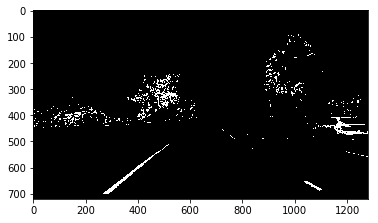

In [10]:
# Find yellow lines
binary_yellow = np.zeros_like(gray)
binary_yellow[(binary_yws == 1)& (binary_yh == 1)] = 1
plt.imshow(binary_yellow, cmap="gray")

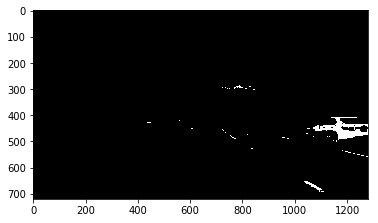

In [11]:
# Find white lines
binary_white = np.zeros_like(gray)
binary_white[(binary_yws == 1)& (binary_wl == 1)] = 1
#binary_white = binary_yws + binary_wl
plt.imshow(binary_white, cmap="gray")

In [1]:
# Combine Yellow and white lines
binary_both = np.zeros_like(gray)
binary_both[(binary_yellow==1)|(binary_white==1)]=1
plt.imshow(binary_both, cmap="gray")

NameError: name 'np' is not defined

In [10]:
# In this code cell i show color thresholded video
# Import everything needed to edit/save/watch video clips
from LaneFinder.colorthreshold import color_threshold as ct
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
%matplotlib inline

#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("challenge_video.mp4")
print("Duration of clip: ", clip1.duration)
print("FPS of clip:, ", clip1.fps)
i_frame_ms = 1 / clip1.fps * 1000  # Interval between frames in milliseconds
print("Interval between frames {}ms".format(i_frame_ms))
frame_iter = clip1.iter_frames()
 
for frame in frame_iter:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = ct(frame).astype(dtype=np.float32)
    cv2.imshow('image', frame)
    if cv2.waitKey(int(i_frame_ms)) & 0xFF == ord('q'):
        break

#frame = clip1.get_frame(1)
#frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#frame = ct(frame).astype(dtype=np.float32)
#cv2.imshow('image', frame)
cv2.waitKey(5000)
cv2.destroyAllWindows()

Duration of clip:  16.15
FPS of clip:,  29.97002997002997
Interval between frames 33.36666666666667ms


mean: 1.5707963267948966


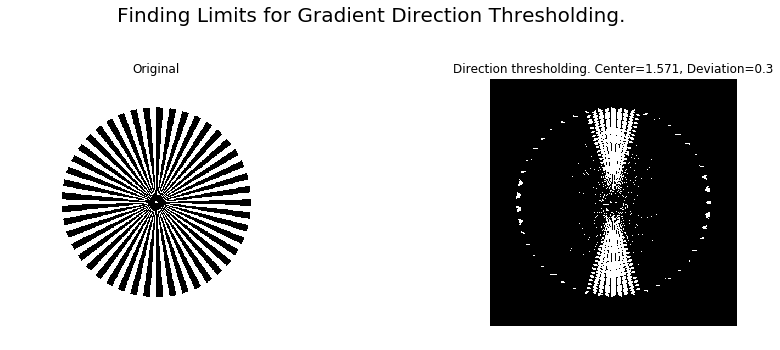

In [54]:
from LaneFinder.gradient_threshold import *
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('./LaneFinder/test_images/sector_45_cycles.jpg')

#img = cv2.imread('./test_images/600px-Siemens_star.svg.png')
#img = cv2.undistort(img, mtx, dist, None, None)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ksize=5
mu = np.pi / 2
dev = 0.3
print("mean:", mu)
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(mu-dev, mu+dev))
# plt.imshow(dir_binary, cmap="gray")

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Finding Limits for Gradient Direction Thresholding.", fontsize=20)

# Show original image
a = fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(gray, cmap='gray')
# Show thresholded image
a = fig.add_subplot(2, 2, 2)
plt.title("Direction thresholding. Center={:.3f}, Deviation={}".format(mu, dev))
plt.axis('off')
plt.imshow(dir_binary, cmap='gray')

plt.savefig("./illustrations/grad_direction_thresholding_sectors.jpg")

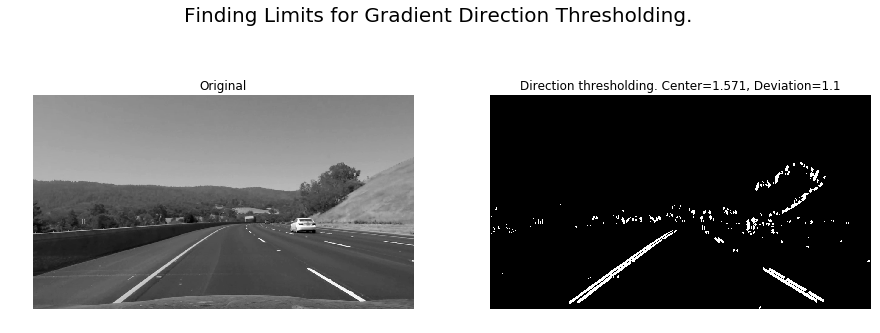

In [53]:
from LaneFinder.gradient_threshold import *
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('./illustrations/project_video.mp4_curve.jpg')

#img = cv2.imread('./test_images/600px-Siemens_star.svg.png')
#img = cv2.undistort(img, mtx, dist, None, None)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.undistort(gray, mtx, dist, None, None)
ksize=13
#mu = 1.5
mu = np.pi / 2
dev = 1.1
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(mu-dev, mu+dev))

mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))

combined = np.zeros_like(dir_binary)
combined[((mag_binary == 1) & (dir_binary == 1))] = 1

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Finding Limits for Gradient Direction Thresholding.", fontsize=20)

a = fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(gray, cmap='gray')
a = fig.add_subplot(2, 2, 2)
plt.title("Direction thresholding. Center={:.3f}, Deviation={}".format(mu, dev))
plt.axis('off')
plt.imshow(combined, cmap='gray')

plt.savefig("./illustrations/grad_lane_line_threshold.jpg")

## Warping the image

Image size is:  (720, 1280, 3)


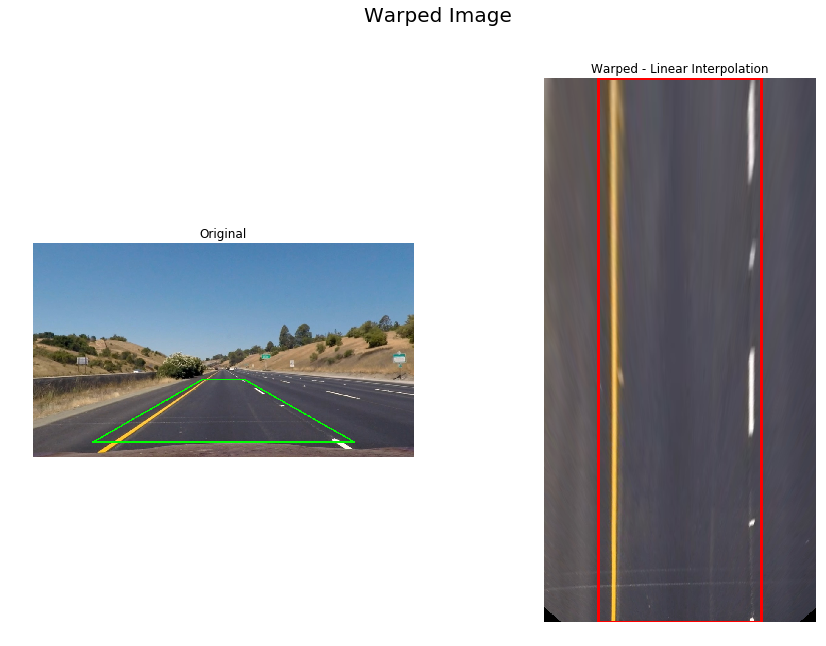

In [50]:
image = cv2.imread('./test_images/straight_lines1.jpg')
#image = cv2.imread('./test_images/test6.jpg')
image = cv2.undistort(image, mtx, dist, None, None)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#image_size = (image.shape[1], image.shape[0])
print("Image size is: ", image.shape)
image_size = (128, 256)
# TR, BR, BL, TL
#src = np.array([[685, 445],
#                [1030, 670],
#                [278, 670],
#                [599, 445]], dtype=np.float32)

# These coordinates assumes that camera is exactly on horizontal center of vehicle
# Original image size is 1280, 720
yt = 460    # Y-top
yb = 670    # Y-bottom
src = np.array([[710, yt],     # Top-Right
                [1080, yb],    # Bottom-Right
                [200, yb],     # Bottom-Left
                [569, yt]],    # Top-Left
               dtype=np.float32)
image_size = (256, 512)
dst = np.array([[image_size[0]*0.8, image_size[1]*0],   # * 0.1
                [image_size[0]*0.8, image_size[1]],       # * 0.9
                [image_size[0]*0.2, image_size[1]],       # * 0.9
                [image_size[0]*0.2, image_size[1]*0]],  # * 0.1 
               dtype=np.float32)  


M = cv2.getPerspectiveTransform(src, dst)


# Warp perspective
warped_linear = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
warped_cubic = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_CUBIC)

# Draw warp rectangle to original image
#print(src)
vertices_src = src.reshape((-1,1,2)).astype(dtype=np.int32)
#pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
#vertices = pts.reshape((-1,1,2))
#print(vertices_src)
cv2.polylines(image, [vertices_src], True, [0,255,0], 3)

vertices_dst = dst.reshape((-1,1,2)).astype(dtype=np.int32)
cv2.polylines(warped_linear, [vertices_dst], True, [255,0,0], 2)
cv2.polylines(warped_cubic, [vertices_dst], True, [255,0,0], 2)

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Warped Image", fontsize=20)

#Show original image
a = fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(image)
# Show warped image
a = fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title("Warped - Linear Interpolation")
plt.imshow(warped_linear)

#a = fig.add_subplot(1, 3, 3)
#plt.axis('off')
#plt.title("Warped - Cubic Interpolation")
#plt.imshow(warped_cubic)

plt.savefig("./illustrations/warped.jpg")
plt.savefig("./output_images/tmp.jpg")

## Using histogram to detect lane line peaks

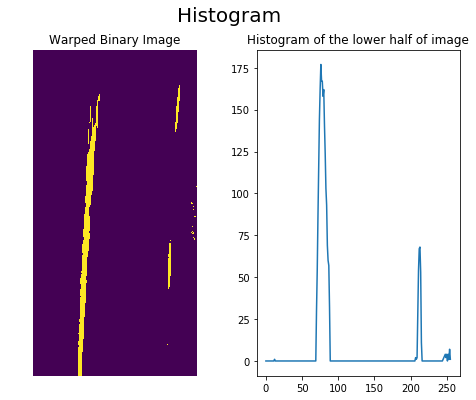

In [44]:
# Histogram
import numpy as np
from LaneFinder.pipeline import Pipeline_LanePixels
#image = cv2.imread('./test_images/straight_lines1.jpg')
image = cv2.imread('./test_images/test6.jpg')
image = cv2.undistort(image, mtx, dist, None, None)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

pipe = Pipeline_LanePixels()
pipelined = pipe.apply(image)


# Create histogram
histogram = np.sum(pipelined[pipelined.shape[0]//2:,:], axis=0)
#plt.plot(histogram)


fig = plt.figure(figsize=(8, 6))
fig.suptitle("Histogram", fontsize=20)

# Show warped image
a = fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title("Warped Binary Image")
plt.imshow(pipelined)
# Plot histogram
a = fig.add_subplot(1, 2, 2)
#plt.axis('off')
plt.title("Histogram of the lower half of image")
plt.plot(histogram)

plt.savefig("./illustrations/binary_warped_image.jpg")

In [51]:
# Generate here pipeline images
from Camera import CameraBase as Cam
from LaneFinder.pipeline import Pipeline_LanePixels

cam = Cam()
cam.load_params("udacity_project_calibration.npy")
p = Pipeline_LanePixels()

SyntaxError: invalid syntax (<ipython-input-51-554d992f98e7>, line 16)